## Load product data

In [372]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import copy as cp
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,Birch,AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn import preprocessing

from scipy.cluster import hierarchy
from scipy import stats
from scipy.stats import mstats

from IPython.display import display

%load_ext autoreload
%autoreload 1
%aimport Helpers

import Helpers as hlp

pd.options.display.float_format = '{:,.2f}'.format

interim_path = "..\\data\\interim\\"

file_name = "HistPerProduct_p2c1.csv"
df_HistPerProduct_p2c1 = pd.read_csv(interim_path + file_name , sep = ";", encoding = 'utf-8', header = 0)


product_raw_df = df_HistPerProduct_p2c1
cols = product_raw_df.columns.values
cols[0]  = 'product'
product_raw_df.columns =cols
print(product_raw_df.shape)
#product_raw_df.iloc[:,1:].apply(stats.zscore,axis=1).head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(457, 105)


# Cleaning Series

## Trailing zeros
Remove the products that werent sold in the last 15 weeks

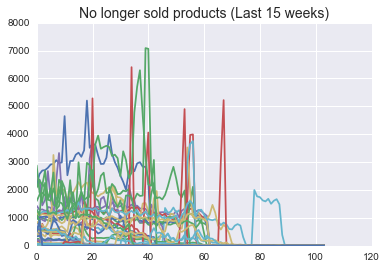

Series With 15 trailing zeros removed
Removed: 109 , Remaining: 348


In [373]:
product_df = product_raw_df.fillna(0).iloc[:,1:].copy()
t = 15

#mask on the t last columns being >0
mask = (product_df.iloc[:,-t:]==0).all(axis=1)

for index, row in product_df[mask].iterrows():
    plt.plot(list(row))
plt.title("No longer sold products (Last %d weeks)"%t,size=14)
plt.show()


product_df = product_df[~mask]
print("Series With %d trailing zeros removed"%t)
print("Removed: %d , Remaining: %s"%(mask.astype(int).sum(),product_df.shape[0]))

## Rare sales
Remove the products that werent sold for at least 5 weeks

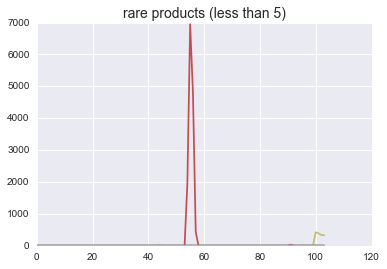

Series With less than 5 values removed
Removed: 11 , Remaining: 337


In [374]:
t = 5

rare =(product_df.where(product_df==0,other=1.).sum(axis=1)<=t)

for index, row in product_df[rare].iterrows():
    plt.plot(list(row))
plt.title("rare products (less than %d)"%t,size=14)
plt.show()


product_df = product_df[~rare]
print("Series With less than %d values removed"%t)
print("Removed: %d , Remaining: %s"%(rare.astype(int).sum(),product_df.shape[0]))

## Recently launched
Remove the products which werent sold in the 25 first weeks

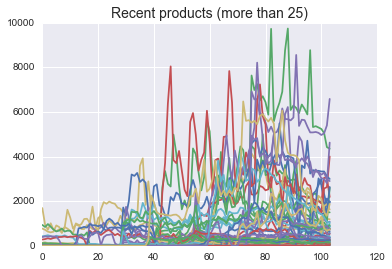

Series With more than 25 zeros removed
Removed: 89 , Remaining: 248


In [375]:
t = 25

recent =(product_df == 0).astype(int).sum(axis=1)>t

for index, row in product_df[recent].iterrows():
    plt.plot(list(row))
plt.title("Recent products (more than %d)"%t,size=14)
plt.show()


product_df = product_df[~recent]
print("Series With more than %d zeros removed"%t)
print("Removed: %d , Remaining: %s"%(recent.astype(int).sum(),product_df.shape[0]))

In [376]:
product_df_clean = product_df

In [428]:
product_df = product_df_clean

### Remove Outliers
Use Winsorizing

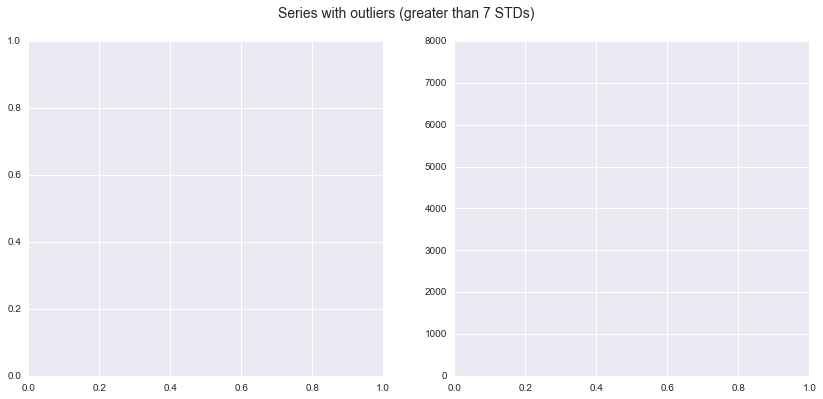

In [427]:
product_df_w = product_df.apply(mstats.winsorize,limits = (0.06,0.02),axis=1)
t = 7

out = (product_df.where(np.abs(stats.zscore(product_df,axis=1))>t,other=0).astype(bool)).any(axis=1)
out2 = (product_df_w.where(np.abs(stats.zscore(product_df_w,axis=1))>t,other=0).astype(bool)).any(axis=1)

plt.figure(figsize=(14,6))

plt.suptitle("Series with outliers (greater than %d STDs)"%t,size=14)#[182,368,382,77,163]
plt.subplot(1,2,1)
for index, row in product_df[out].iterrows():
    plt.plot(list(row))

plt.subplot(1,2,2)
for index, row in product_df_w[out].iterrows():
    plt.plot(list(row))

plt.ylim(0,8000)
plt.show()



product_df = product_df_w

# Pre-process Data
We end up with 248 product. Apply a Z-normalization (subtract the mean and divide by the standard deviation)

In [383]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = product_df.as_matrix().astype(float)

#stanrdize data 
std_scaler = StandardScaler(with_mean=True, with_std=True).fit(data.T)
X_z = std_scaler.transform(data.T).T

#normalize data
minMax_scaler = MinMaxScaler().fit(data.T)
X_n = minMax_scaler.transform(data.T).T

product_codes = product_raw_df['product'][product_df.index]

product_df_full = pd.DataFrame(X_z, columns = product_df.columns,index=product_df.index)
product_df_full.insert(0,'product',product_codes)


N,M  = X_z.shape

# Filtering Series
Applying a moving average or an other ARIMA filters to the series

### ARIMA Models

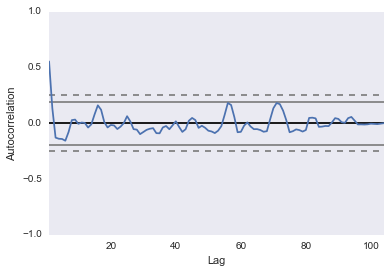

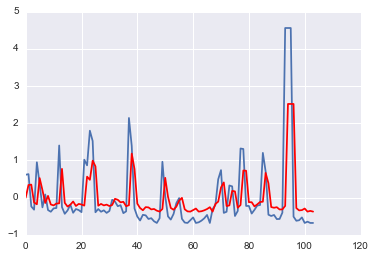

In [434]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.tools.plotting import autocorrelation_plot


s = product_df_full.loc[170].values[1:]



autocorrelation_plot(s)
plt.show()

model = ARIMA(s, order=(1, 0, 0))
results_ARIMA = model.fit(disp=-1, trend='nc',method = 'css-mle')#start_params=(2,2)   


dim = X_z.shape[1]
new_dim = results_ARIMA.fittedvalues.shape[0]



plt.plot(range(0,dim),s)
plt.plot(range(dim - new_dim,dim),results_ARIMA.fittedvalues, c='red')
plt.show()

# X_z_f = []
# for i,s in enumerate(X_z):
#     model = ARIMA(s, order=(0, 2, 2))
#     results_ARIMA = model.fit(disp=-1, trend='nc') 
#     X_z_f +=[results_ARIMA.fittedvalues]

# X_z_f = np.array(X_z_f)
# print(X_z_f.shape)


### Rolling mean

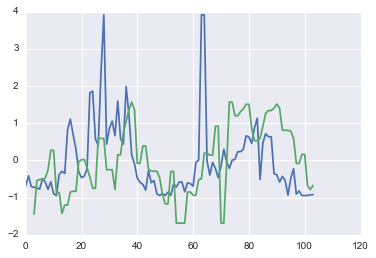

In [412]:
# %load_ext autoreload
# %autoreload 1
# %aimport Helpers
df = pd.DataFrame(X_z)

#Rolling mean
s = X_z[1]
window = 3

rolled = df.rolling(window=window,axis=1).median()
X = rolled.iloc[0,window:].values
plt.plot(np.arange(0,M),s)
plt.plot(np.arange(window,M),X)
plt.show()

In [360]:
X_z = X_z_f



# Principal Components Analysis
Apply a PCA on raw data (standardized), plot the the individual cloud then the correlation circle

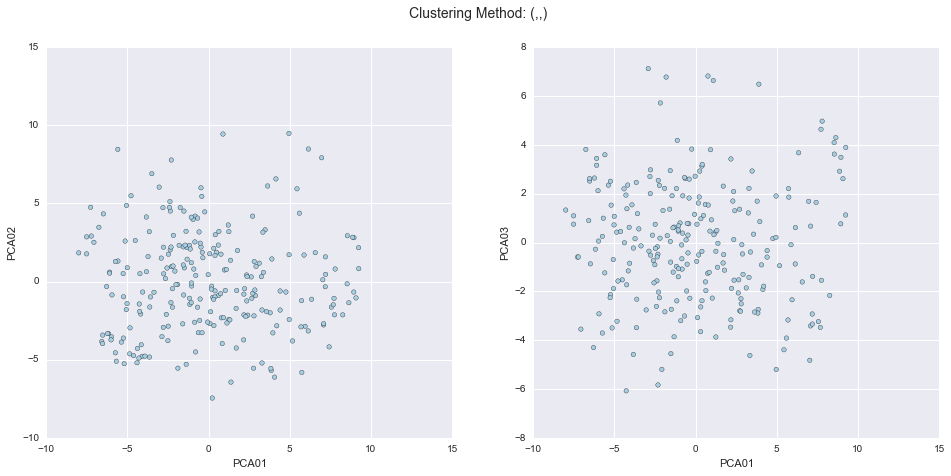

[ 0.18555745  0.10993597  0.06472891  0.05182542  0.0387322 ]


In [387]:
%matplotlib inline

X = X_z
nb_col=X.shape[1]
pca = PCA(n_components = nb_col)

pca.fit(X)  
princ_axis = pca.components_

X_pca= pca.transform(X)

hlp.Clusters_plot(X= X_pca, labels = np.zeros(len(X_pca)))
inertie = pca.explained_variance_ratio_
print(inertie[0:5])
comp = np.transpose(princ_axis)


# hlp.circleOfCorrelations(comp,inertie,product_df.columns)
plt.show(block = True)

## PCA 01
It regroups products being sold more over time ie __increasing trend__ over the last two years

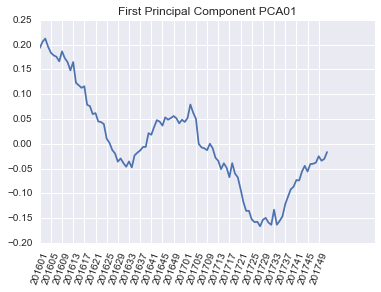

In [388]:
%matplotlib inline

tick_frequency = 4

plt.title("First Principal Component PCA01")
plt.plot(range(nb_col), princ_axis [0,:])
plt.xticks(range(nb_col)[::tick_frequency], list(product_df.columns)[::tick_frequency], rotation = 70)
plt.show()

## PCA 02
Opposes products in term of __sales seasonality__ being sold either in cold or hot seasons

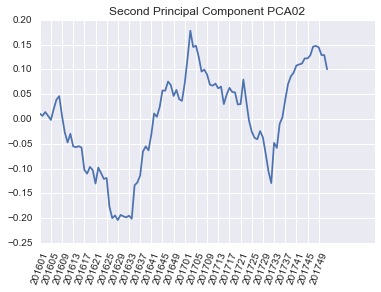

In [389]:
plt.title("Second Principal Component PCA02")
plt.plot(range(nb_col), princ_axis [1,:])
plt.xticks(range(nb_col)[::tick_frequency], list(product_df.columns)[::tick_frequency], rotation = 70)
plt.show()

## PCA 03
The curve seems strongly correlated to __one sales period__. Probably of one product 

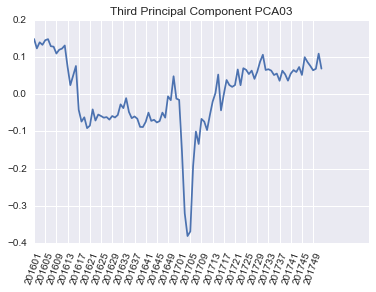

In [390]:
plt.title("Third Principal Component PCA03")
plt.plot(range(nb_col), princ_axis [2,:])
plt.xticks(range(nb_col)[::tick_frequency], list(product_df.columns)[::tick_frequency], rotation = 70)
plt.show()

### Plot the samples with the strongest correlation to components
On récupère les examples qui sont le plus corrélés avec un axe principal donné

In [391]:
%load_ext autoreload
%autoreload 1
%aimport Helpers

component = 3
corrSamples = hlp.GetMostCorrelatedTo(X_pca,component,index=product_df.index)
corrSamples.head()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,1,2,3,4,5,6,7,8,9,10,...,95,96,97,98,99,100,101,102,103,104
368,2.92,1.50,7.12,3.05,1.02,1.60,1.69,0.17,0.06,1.04,...,0.10,0.09,0.06,0.14,0.02,0.09,0.06,0.04,0.21,0.00
382,0.76,1.75,6.82,4.37,0.97,1.38,2.13,0.47,0.58,1.32,...,0.12,0.12,0.12,0.03,0.36,0.12,0.33,0.02,0.31,0.00
77,1.82,2.32,6.78,3.83,0.66,2.17,1.60,0.39,0.38,1.29,...,0.22,0.33,0.29,0.27,0.06,0.21,0.07,0.07,0.17,0.00
182,1.09,0.77,6.64,4.58,0.02,1.22,0.65,0.43,0.69,0.27,...,0.08,0.13,0.07,0.21,0.18,0.30,0.04,0.12,0.12,0.00
163,3.89,1.45,6.49,0.48,2.18,0.65,0.42,1.04,1.46,0.27,...,0.01,0.15,0.01,0.10,0.04,0.03,0.20,0.05,0.05,0.00


### Compare the Most Correlated sample to its principal component
On vérifie si la séquence de l'exemple le plus corrélé suit le schéma de l'axe principal

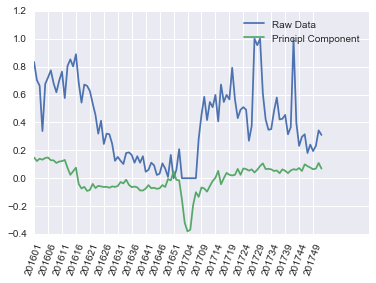

In [392]:
sample = corrSamples.index[3]

p_axe = princ_axis [component-1,:]
x = product_df.loc[sample]
normalized = (x-min(x))/(max(x)-min(x))

tick_frequency = 5
plt.plot(range(nb_col),normalized, label="Raw Data")
plt.plot(range(nb_col),p_axe , label="Principl Component")
plt.xticks(range(nb_col)[::tick_frequency], list(product_df.columns)[::tick_frequency], rotation = 70)
plt.legend()
plt.show()

# Clustering
Try out Hierarchical clustering, kMeans and kMedodis  on raw data. Then, plot the PCA to visualize the result of the clustering on the principal components

## Agglomerative - Automated Cut-Off Selection

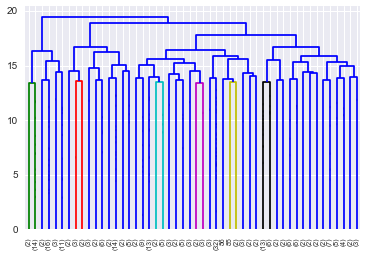

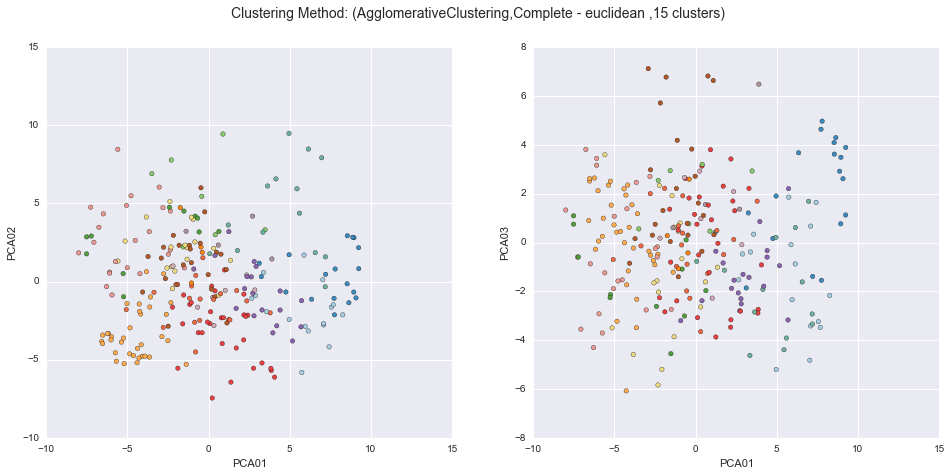

In [397]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
SSE = {}

Z = hierarchy.linkage(X_z, method='complete',metric='euclidean')
dn = hierarchy.dendrogram(Z, truncate_mode='lastp', p=50, leaf_rotation=90., leaf_font_size=7., show_contracted=True)
plt.show()



plt.figure()
labels_h_cc = hierarchy.fcluster(Z, t=15 ,criterion = 'maxclust')
hlp.Clusters_plot(X= X_pca, labels = labels_h_cc,info=["AgglomerativeClustering","Complete - euclidean ","%d clusters"%len(set(labels_h_cc))])


SSE["Agg_complete"] = hlp.getSSE(X_z,X_z[labels_h_cc])

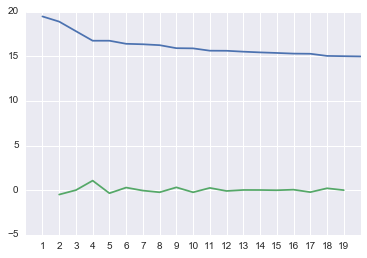

clusters: [ 4  2  5  9  6 11 10  8 17 18 12 16  7 13 14 15  3 19]


In [398]:
last = Z[-20:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.xticks(np.arange(1,len(last)))
plt.show()
best_ks = np.abs(acceleration_rev).argsort()[::-1]
k =  best_ks+ 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:", k)

### K-Means: Validate different numbers of clusters

clusters: [28  7 26 22 24 36 15 30 34  9 40 11 38 32 17 13 21 19]


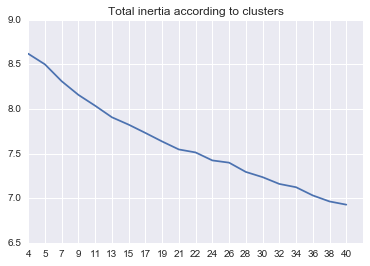

In [401]:
%matplotlib inline
clusters= np.linspace(4,40,20).astype(int)
inertia = []
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, random_state=0).fit(X_z)
    inertia += [np.sqrt(kmeans.inertia_/len(kmeans.labels_))]
    
inertia = np.array(inertia)
plt.title("Total inertia according to clusters")    
plt.plot(np.arange(0,len(clusters)),inertia)#scale it to acc2
plt.xticks(np.arange(0,len(clusters)),clusters)
acc = np.diff(inertia, 2)  # 2nd derivative of the inertia curve
#plt.plot(np.arange(2,len(clusters)), acc)
best_ks = np.abs(acc).argsort()[::-1]
k =  best_ks+ 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:",clusters[k])
plt.show()


## Ward Clustering

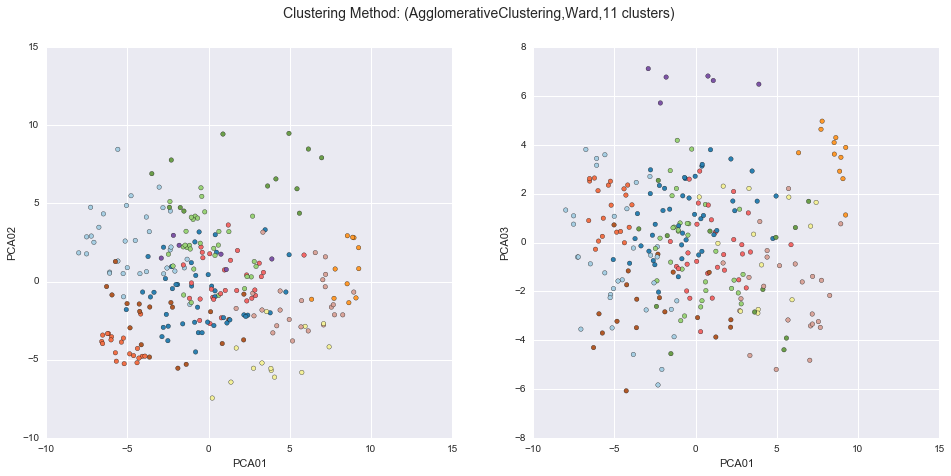

In [402]:
n_cluster = 11

from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward').fit(X_z)
label = ward.labels_

SSE['Ward'] = hlp.getSSE(X_z,X_z[label])
hlp.Clusters_plot(X= X_pca, labels = label,info=["AgglomerativeClustering","Ward","%d clusters"%len(set(label))])

## K-means

In [403]:
%matplotlib inline

kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(X_z)
label = kmeans.labels_
labels_kmeans = label

SSE["kMeans"] = hlp.getSSE(X_z,X_z[labels_kmeans])

### PCA representation of the clustering

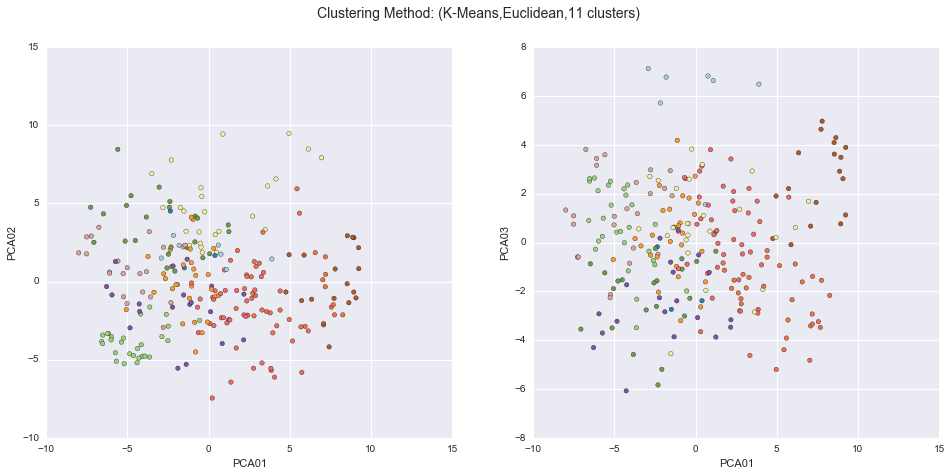

In [404]:
X = X_pca[:,:3]
hlp.Clusters_plot(X= X_pca, labels = label,info=["K-Means","Euclidean","%d clusters"%len(set(label))])

### TSNE representation of the clustering

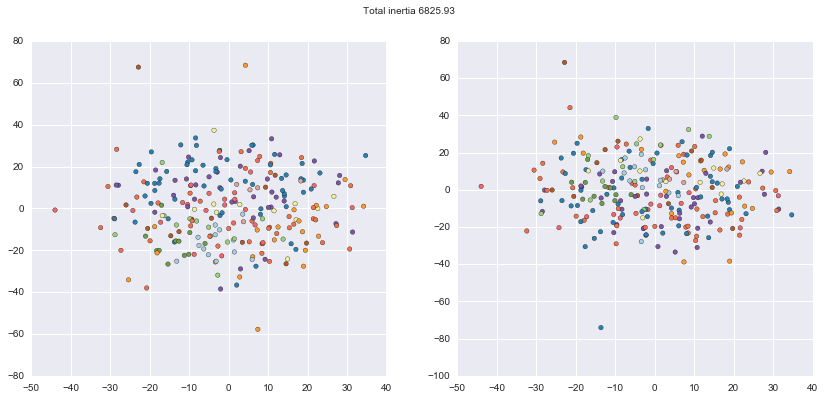

In [250]:
%matplotlib inline


X_tsne = TSNE(n_components = 3).fit_transform(X_z)

plt.figure(figsize=(14,6))
colors = [str(item/255.) for item in labels_kmeans]
plt.suptitle("Total inertia %.02f"%kmeans.inertia_)  
plt.subplot(1,2,1)
plt.scatter(X_tsne[:,0],X_tsne[:,1],cmap ="Paired" ,c=colors)
plt.subplot(1,2,2)
plt.scatter(X_tsne[:,0],X_tsne[:,2],cmap ="Paired" ,c=colors)
plt.show(block = True)

# Custom Distances

In [405]:
from scipy.stats import spearmanr
def spearmanr_dist(x,y):
    rho, pval = spearmanr(x,y)
    return rho


r,p = spearmanr(X_z)
np.fill_diagonal(r,0)

In [406]:
%load_ext autoreload
%autoreload 1
%aimport Helpers


import kMedoids
from scipy.spatial.distance import pdist,squareform

n_obs = X_z.shape[1]
corr_distance = squareform(pdist(X_z, 'correlation'))
euclid_distance = squareform(pdist(X_z, 'euclidean'))
sqcorr_distance = corr_distance**2
#spearman_distance = squareform(pdist(X_z, lambda u, v: spearmanr_dist(u,v)))



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## K-medoids (Correlation distance)

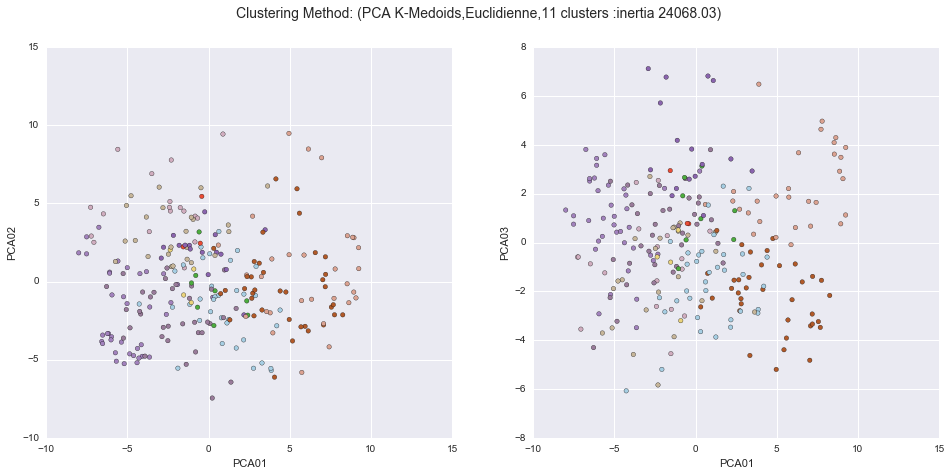

In [407]:
label, medoids = kMedoids.cluster(euclid_distance,k= n_cluster)
labels_kmedoids = label

labels_kmedoids_corr,medoids = kMedoids.cluster(corr_distance,k= n_cluster)
labels_kmedoids_spear,medoids = kMedoids.cluster(corr_distance,k= n_cluster)


SSE["kMedoids"] = hlp.getSSE(X_z,X_z[labels_kmedoids])
SSE["kMedoids_corr"] = hlp.getSSE(X_z,X_z[labels_kmedoids_corr])
SSE["kMedoids_spear"] = hlp.getSSE(X_z,X_z[labels_kmedoids_spear])


hlp.Clusters_plot(X= X_pca, labels = label
                  ,info=["PCA K-Medoids","Euclidienne","%d clusters :inertia %.2f"%(len(set(label)),SSE["kMedoids"])])
#hlp.Clusters_plot(X= X_tsne, labels = label,info=["TSNE K-Medoids","Correlation","%d clusters"%len(set(label))])

In [408]:
for k,v in SSE.items():
    print(" \"%s\" : %.2f"%(k,v))

 "kMedoids_corr" : 25285.71
 "kMeans" : 48092.62
 "Agg_complete" : 44874.71
 "Ward" : 47167.91
 "kMedoids" : 24068.03
 "kMedoids_spear" : 24186.43


# Save Clustering Results

In [411]:
processed_path = "..\\data\\processed\\"
file_name = "p2c1_clustering_clean.csv"

def labels_to_df(labels):
    clusters = dict()

    for i,l in enumerate(list(set(labels))):
        clusters[l] = i+1

    groups = list(product_df_full['product'])
    rows=[]
    for i,g in enumerate(groups):
        c = labels[i]
        rows.append([g,clusters[c],groups[c]])


    label_df = pd.DataFrame(rows,index = labels,columns = ["Product Group key","Cluster","Centroid"])
    return label_df




eucl_df = labels_to_df(labels_kmedoids)
corr_df = labels_to_df(labels_kmedoids_corr)
spear_df = labels_to_df(labels_kmedoids_spear)

eucl_df.to_csv(interim_path+file_name, sep=';', encoding='utf-8')

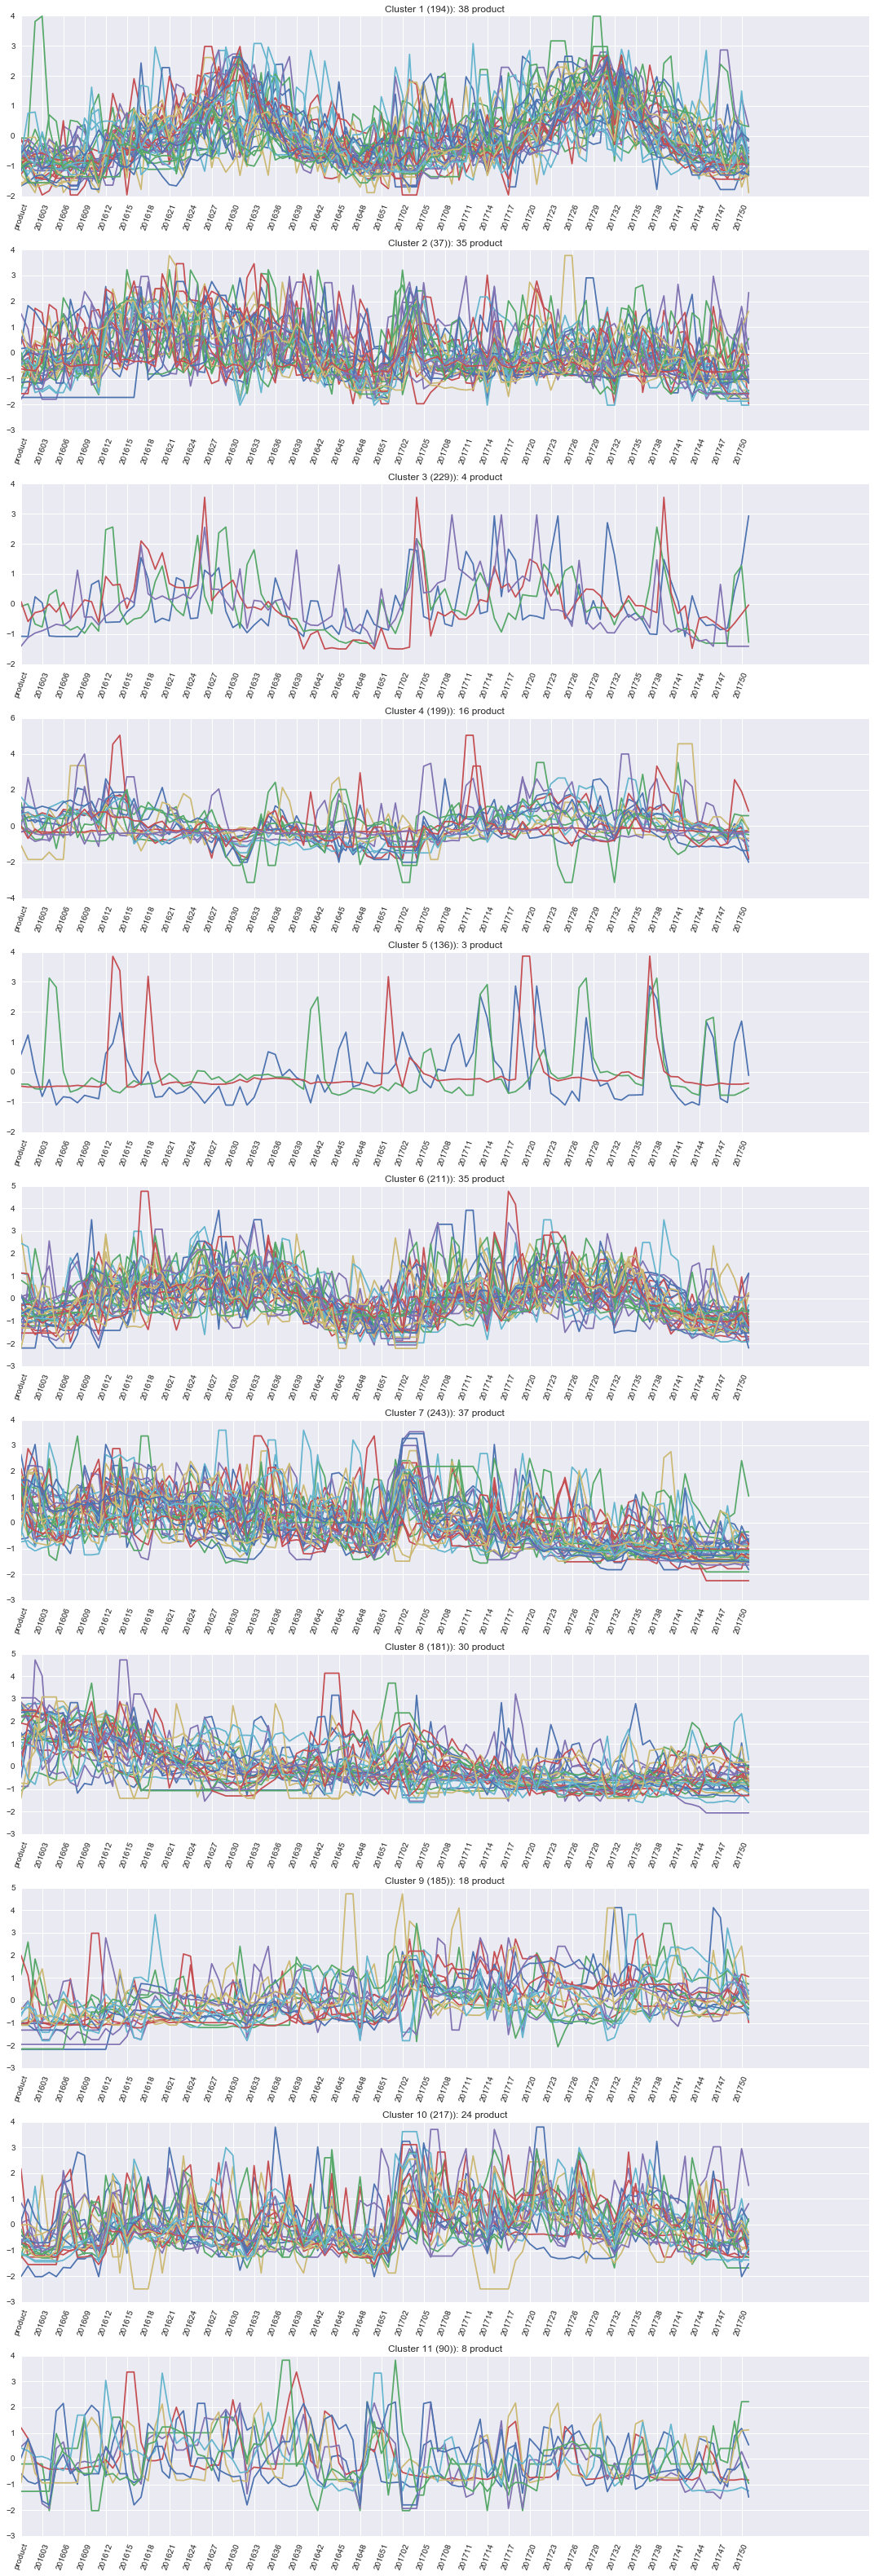

In [410]:
carr =Cluster_series_plot(data_df = product_df_full, cluster_df = eucl_df)

In [471]:
carr =Cluster_series_plot(data_df = product_df_full, cluster_df = corr_df)

In [588]:
carr =Cluster_series_plot(data_df = product_df_full, cluster_df = spear_df)

# Display Clustering Results

In [194]:
def Cluster_series_plot(data_df,cluster_df):
    
    list_it = list(range(len(data_df.columns)))
    tick_frequency = 3
    
    clusters = list(set(cluster_df['Cluster']))
    nc = len(clusters)
    
    clusters_array = []
    
    plt.figure(figsize=(15,nc*4))
    for i,c in enumerate(clusters):
        plt.subplot(nc,1,i+1)
        cluster = list(cluster_df[cluster_df['Cluster']==c].iloc[:,0])
        medoid  = cluster_df[cluster_df['Cluster']==c].index[0]
        plt.title("Cluster %d (%d)): %d product"%(i+1,medoid,len(cluster)))
        mask = (data_df['product'].isin(cluster))
        df  = data_df[mask]
        for index, row in df.iterrows():
            plt.plot(list(row)[1:],label = index)
        plt.xticks(list_it[::tick_frequency], list(data_df.columns)[::tick_frequency], rotation = 70)
        clusters_array += [[i,cluster]]
        #plt.legend(loc=0)
    plt.tight_layout()
    #plt.show()
    return clusters_array

## BIRCH Algorithm

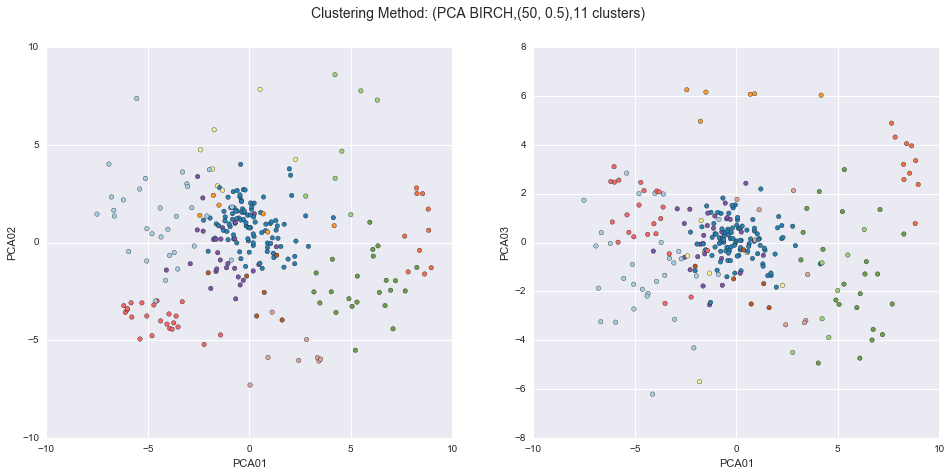

In [258]:
label = Birch(n_clusters= n_cluster, threshold=0.5, compute_labels=True).fit_predict(X_z)
labels_birch = label

SSE["Birch"] = hlp.getSSE(X_z,X_z[labels_birch])

hlp.Clusters_plot(X= X_pca, labels = label,info=["PCA BIRCH","(50, 0.5)","%d clusters"%len(set(label))])

## SOM

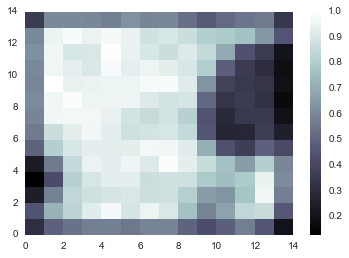

In [37]:
from minisom import MiniSom   


som = MiniSom(14, 14, 104, sigma=0.5, learning_rate=0.01) # initialization of 6x6 SOM

som.train_batch(X_z, 1000) # trains the SOM with 100 iterations

# Plotting the response for each pattern in the iris dataset
plt.bone()
plt.pcolor(som.distance_map().T)  # plotting the distance map as background
plt.colorbar()

qnt = som.quantization(X_z)
x,y = som.winner(X_z[0])


plt.show()




# SOM with SOMpy

In [280]:
import sompy
mapsize = [14,14]
som = sompy.SOMFactory().build(Data1, mapsize, mask=None, mapshape='planar', lattice='rect', normalization='var', initialization='pca', neighborhood='gaussian', training='batch', name='sompy')  
# this will use the default parameters, but i can change the initialization and neighborhood methods
som.train(n_job=1, verbose='info')  # verbose='debug' will print more, and verbose=None wont print anything

# Fuzzy c-means

In [264]:
import skfuzzy as fuzz

ncenters = n_cluster
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X_z.T, ncenters, 2, error=0.005, maxiter=1000, init=None)



labels_fuzzy = np.argmax(u, axis=0)

## Representation methods
### PAA_SAX representation

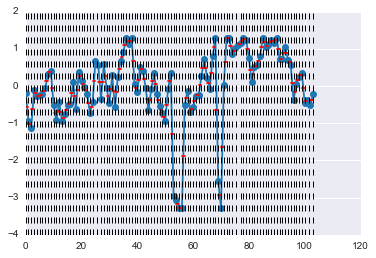

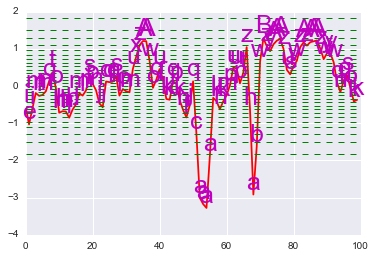

In [393]:
from pyts.transformation import PAA,SAX
from pyts.visualization import plot_paa, plot_sax
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
ts = X_z[0].reshape(1,-1)

paa_win = 100
sax_bin = 30


#PAA example
paa = PAA(window_size=None, output_size=paa_win, overlapping=True)
X_paa = paa.transform(ts)
plot_paa(ts[0], window_size=None, output_size=paa_win, overlapping=True, marker='o')

#SAX example
sax = SAX(n_bins=sax_bin, quantiles='gaussian')
X_sax = sax.transform(X_paa)
plot_sax(X_paa[0], n_bins=sax_bin, quantiles='gaussian')
plt.show()

#Extract SAX vector
X_SAX= []
for x in X_z:
    ts = x.reshape(1,-1)
    paa = PAA(window_size=None, output_size=paa_win, overlapping=True)
    X_paa = paa.transform(ts)
    sax = SAX(n_bins=sax_bin, quantiles='gaussian')
    X_sax = sax.transform(X_paa)[0]
    X_SAX.append(list(X_sax))

#Cast back to int
X_SAX = np.array(X_SAX).astype('|S1')
X_SAX = X_SAX.view(np.uint8) - 98
# X_z = X_SAX
# N,M  = X_z.shape
